### SARS-COV-2 FORECASTING WITH GOOGLE TRENDS ###  
During the Coronavirus pandemic, many tried monitoring, predicting and understading the *patterns* of various indicators of the gravity, or **severity** of the virus, like the number of positive cases in a given area or the daily number of deaths: the main goal was to give a clear indication of how the disease evolved in near-real time.  
In this notebook, I select five queries from Google Trends related Covid-19 and employ them as external regressors for a LASSO model. The three main indicators I choose to monitor and forecast from the [Italian Civil Defense Department](https://github.com/pcm-dpc/COVID-19) Coronavirus dataset are: 
1. the number of new positive cases by day;
2. the number of patients in intensive care units;
3. the daily number of deaths.


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
import warnings

## COVID-19 IN ITALY

In [88]:
cov_data=pd.read_csv('cov_data_ita.csv', index_col=0, parse_dates=[0])
cov_data.head()

,intensive_care,hospitalised,tot_positives,delta_tot_positives,new_positives,deceased,delta_icus,delta_deceased
2020-02-25,35,150,311,90,93,10,9.0,3.0
2020-02-26,36,164,385,74,78,12,1.0,2.0
2020-02-27,56,304,588,203,250,17,20.0,5.0
2020-02-28,64,409,821,233,238,21,8.0,4.0
2020-02-29,105,506,1049,228,240,29,41.0,8.0


The first severity indicator that we will monitor and (try to) forecast is the number of confirmed **new positive cases** (*new_positives*). Now, the main issue in using the number of positives confirmed daily is that, at the beginning of the pandemic, we weren't that good at tracking cases, and not very efficient in performing tampons: as a result, the numbers up to the end of 2020 are largely underestimated, and even after, are subject to a lot of noise because of difficulties in tracking, delays in communications and other issues. The numbers in 2022 might also might look like a surprise for the steep rise, but we have to consider that in 2022 the Omicron variant of Coronavirus is the more widespread, because of its high infectiousness.  
Having said that, we might want to look for more reliable severity indicators.

Text(0, 0.5, 'Cases')

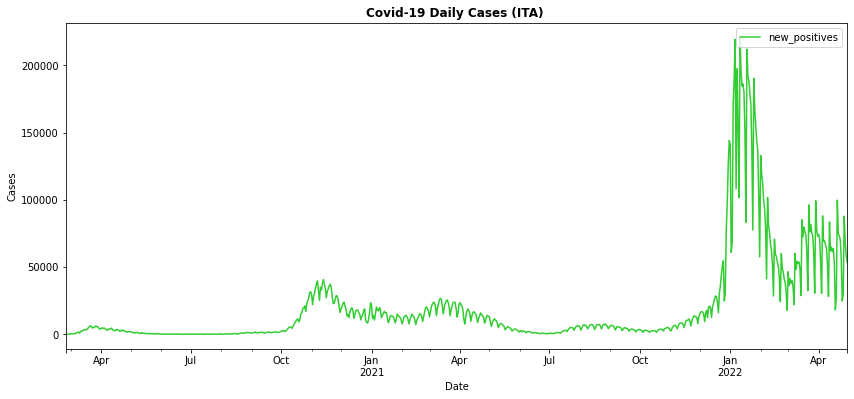

In [89]:
fig, ax = plt.subplots(figsize=(14, 6))
cov_data['new_positives'].plot(color='limegreen')
ax.legend(ncol=1, loc='upper right', frameon=True)
plt.title('Covid-19 Daily Cases (ITA) ', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cases')

The second severity indicator we are going to look at is the number of patients in **intensive care units, or ICUs** (*intensive_care*): one can be tested positive and show no particular symptom (asymtomatic), have only a light headache and a little cough, and those have been (luckily) the majority of cases. Others are less fortunate, and need hospitalization or even and ICU assistance.  
ICUs, as any resource, are not unbuonded and unlimited: they are a **scarce resource** and serve not only Covid patients but also patients and citizens with other health conditions or subject to accidents, in need of immediate assistance. Indeed, the number of people in ICUs in the Country has been used as an indicator of the **actual** severity of the pandemic. This facts made the theme of ***forecasting the number of people with Covid-19 in ICUs*** a particularly crucial topic during the early phases of the pandemic. As can be seen below, the number of Covid patients in ICUs skyrocketed during the first wave of the pandemic (spring 2020) to circa 4000 hospitalized people in need, declined sharply during summer and rose again during the second wave. Vaccines have been made available to the public in the spring of 2021 and their effect can be seen in the summer's decline of patients but also, more importantly, in the way smaller number of people in need of intensive care assistance in autumn and winter 2021/2022.

The last severity indicator is found, of course, in the **daily number of deaths** (*delta_deceased*): as can be seen in the plot, during the first wave Italy's daily deathcount arose steeply up to almost 1000 per day, then declined with the arrive of summer, with the spike in August probably being related to "Ferragosto" and summer's vacation, with many people traditionally gathering in the same holiday places; in October, daily victims rose again, only to see a more decisive decline at the end of spring 2021, with the arrival of Covid vaccines. The third and last (hopefully) wave is the due to a highly contagious variant, but luckily is not comparable to the first two in order of magnitude thanks to vaccines. 

Text(0, 0.5, 'Cases')

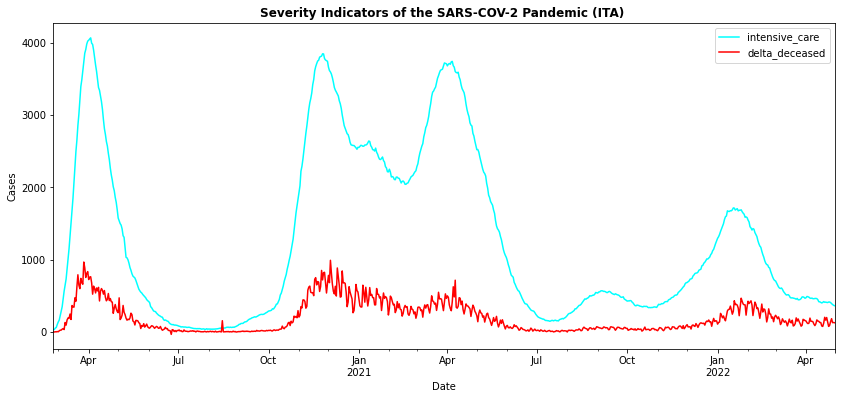

In [90]:
fig, ax = plt.subplots(figsize=(14, 6))
cov_data['intensive_care'].plot(color='cyan')
cov_data['delta_deceased'].plot(color='red')
ax.legend(ncol=1, loc='upper right', frameon=True)
plt.title('Severity Indicators of the SARS-COV-2 Pandemic (ITA) ', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cases')

## WHAT ARE GOOGLE TRENDS AND WHY DO THEY MATTER?

[Google Trends](https://trends.google.it/trends/?geo=IT) is a website that analyzes and lists the popular search results on Google search based on various regions and languages.  
But ***what*** exactly is "Google Trends"? And why is this relevant to Data Scientists?

As [Silva et al, 2019](https://www.mdpi.com/439984) report, Google Trends is a website, and one of the largest *real time dataset*s currently available to the public [Rogers 2016](https://openknowledge.worldbank.org/handle/10986/23723), recording Google search data from 2004 to present [Choi and Varian 2012](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1475-4932.2012.00809.x), Google Trends allows one to **gauge audience & consumer search interest in brands, events, politicians** and much more.

However, instead of the raw level of queries for a given search term, it is important to note that Google Trends reports the query index, which consists in a query share [Choi and Varian 2012](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1475-4932.2012.00809.x):

\begin{equation}
\frac{Total Query Volume For Search Term In A Given Geographic Location}{Total Number Of Queries In that Region At A Point In Time}
\end{equation}

In other words, its ***normalised nature*** (which allows for more accurate comparisons over time) means that Google Trends will always show the search interest on a topic as a proportion of all searches on all topics on Google at that time and location [Rogers 2016](https://openknowledge.worldbank.org/handle/10986/23723). 
**Data quality** is another important issue, and Google Trends seeks to improve the quality of its data by excluding searches made by very few people, duplicate searches and special characters [Choi and Varian 2012](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1475-4932.2012.00809.x).

Furthermore, the query share based approach to computing Google Trends has its benefits in a world where big data and data mining have been marred by privacy issues and concerns: the data aggregation underlying Google Trends ensures the output is **anonymised** and thus no individual is identified personally [Rogers 2016](https://openknowledge.worldbank.org/handle/10986/23723).

## PROPER WAY TO USE GOOGLE TRENDS IN FORECASTING

As the study from [Medeiros & Pires (2021)](https://arxiv.org/pdf/2104.03065.pdf) points out, "*Google makes available only a small sample of its search database. What most researchers and practitioners seem not to know (or to ignore) is the fact that this small sample is ***not always the same***. In fact, it is constantly changing. This means that someone who downloads Google Trend data today will not download the same data tomorrow, even if she filters the same topics, languages and location*".

This is not a feature Google itself wants to hide:  
Information about the subject can be easily found as easily as in the [FAQs](https://support.google.com/trends/answer/4365533?hl=it), where it is clearly stated that, since Google handles billions of research queries per day, it is not possible for it to provide access to the entire dataset, because it would be too large to process quickly. To work around this obstacle, **only a small sample of Google searches** are actually used in Google Trends: by sampling, Google gives access to a dataset that is -*generally*- **representative of all searches**, and that can be processed *within minutes* of an event happening (say you want to know more about the breakout of a pandemic..).

Unfortunately, this also means that someone who downloads data today will not download the same data tomorrow, even if you filter for the same topics, languages and locations.

Text(0, 0.5, 'Query Index')

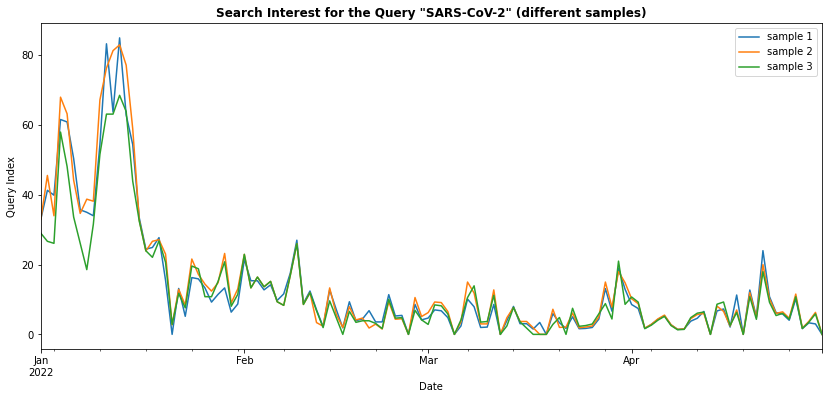

In [91]:
# comparison between two samples: plot
trends_030522 = pd.read_csv('gt_03052022.csv',parse_dates=['date'], index_col=['date'])
trends_040522 = pd.read_csv('gt_04052022.csv',parse_dates=['date'], index_col=['date'])
trends_050522 = pd.read_csv('gt_05052022.csv',parse_dates=['date'], index_col=['date'])
trends_060522 = pd.read_csv('gt_06052022.csv',parse_dates=['date'], index_col=['date'])
trends_090522 = pd.read_csv('gt_09052022.csv',parse_dates=['date'], index_col=['date'])
trends_100522 = pd.read_csv('gt_10052022.csv',parse_dates=['date'], index_col=['date'])
trends_110522 = pd.read_csv('gt_11052022.csv',parse_dates=['date'], index_col=['date'])
trends_120522 = pd.read_csv('gt_12052022.csv',parse_dates=['date'], index_col=['date'])

fig, ax = plt.subplots(figsize=(14, 6))
trends_040522[trends_040522.index >= '2022-01-01']['SARS-CoV-2'].plot(label='sample 1')
trends_090522[trends_090522.index >= '2022-01-01']['SARS-CoV-2'].plot(label='sample 2')
trends_120522[trends_120522.index >= '2022-01-01']['SARS-CoV-2'].plot(label='sample 3')
ax.legend(ncol=1, loc='upper right', frameon=True)
plt.title('Search Interest for the Query "SARS-CoV-2" (different samples)', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Query Index')

Of course, this fact should not stop us from employing Google Trends as a research tool: as [Medeiros & Pires (2021)](https://arxiv.org/pdf/2104.03065.pdf) explain, one of the viable ways to assess and work around this problem is to gather many different samples and then **averaging** across every term, getting a more reliable time series of that term. in brief, *taking averages of many samples, improve the **series consistency***.

Text(0, 0.5, 'Query Index')

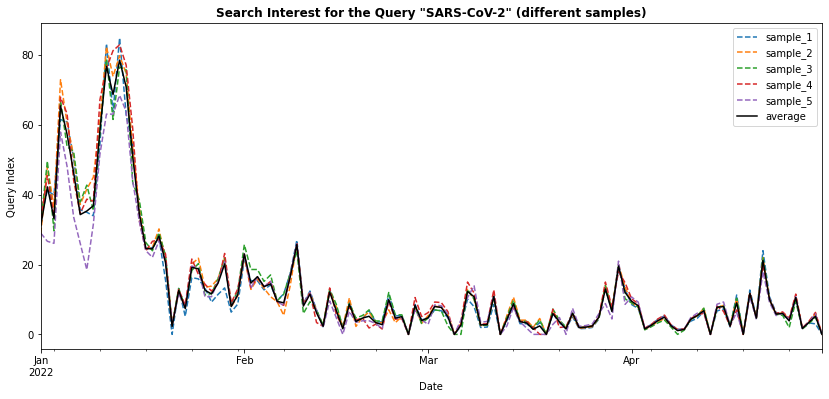

In [92]:
# comparison between averages of many samples
trends_sarscov2 = pd.concat([trends_040522[['SARS-CoV-2']], trends_050522[['SARS-CoV-2']],
                    trends_060522[['SARS-CoV-2']], trends_090522[['SARS-CoV-2']], trends_120522[['SARS-CoV-2']]], axis=1)
trends_sarscov2.columns = ['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']  # same keyword, different samples
trends_sarscov2['SARS-CoV-2'] = trends_sarscov2.mean(axis=1)   # average of all samples 

fig, ax = plt.subplots(figsize=(14, 6))
trends_sarscov2[trends_sarscov2.index >= '2022-01-01']['sample_1'].plot(linestyle='--')
trends_sarscov2[trends_sarscov2.index >= '2022-01-01']['sample_2'].plot(linestyle='--')
trends_sarscov2[trends_sarscov2.index >= '2022-01-01']['sample_3'].plot(linestyle='--')
trends_sarscov2[trends_sarscov2.index >= '2022-01-01']['sample_4'].plot(linestyle='--')
trends_sarscov2[trends_sarscov2.index >= '2022-01-01']['sample_5'].plot(linestyle='--')
trends_sarscov2[trends_sarscov2.index >= '2022-01-01']['SARS-CoV-2'].plot(color='black', label='average')
ax.legend(ncol=1, loc='upper right', frameon=True)
plt.title('Search Interest for the Query "SARS-CoV-2" (different samples)', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Query Index') 

For brevity reason we load a dataframe containing averages collected for many days for the five queries, that we will use as ***external regressors*** for our forecasting model.

## FORECASTING WITH GOOGLE TRENDS

First, we do some visualization to figure out if these queries can be used as a external predictors for each of the variables we are interested in forecasting.

In [93]:
# this trends are already averages of many samples
trends = pd.read_csv('gt_cov_ita.csv',parse_dates=['date'], index_col=['date'])
trends.head()

,Coronavirus,SARS-CoV-2,Covid Symptoms,Covid Vaccine,Intensive Care
date,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN
2020-01-05,0.0,NaN,NaN,NaN,1.09375


Text(0.5, 1.0, 'New Covid Cases & Google Trends')

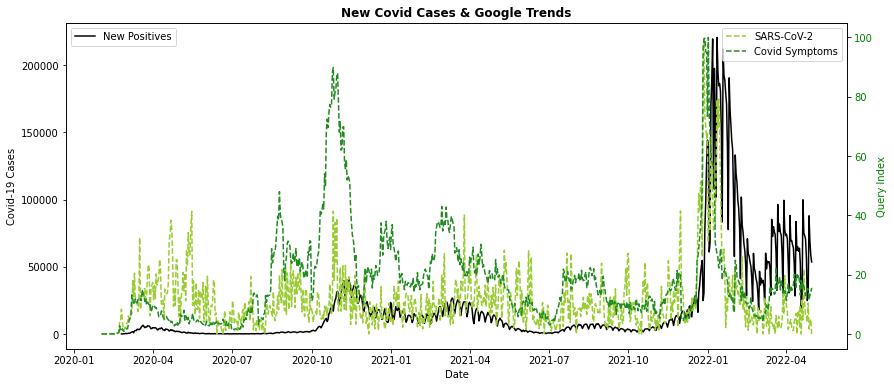

In [94]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Covid-19 Cases')
ax1.plot(cov_data['new_positives'], color='black', label='New Positives')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(ncol=1, loc='upper left', frameon=True)
ax2 = ax1.twinx()
ax2.set_ylabel('Query Index', color='green')
ax2.plot(trends['SARS-CoV-2'], color='yellowgreen', linestyle='--', label='SARS-CoV-2')
ax2.plot(trends['Covid Symptoms'], color='forestgreen', linestyle='--', label='Covid Symptoms')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(ncol=1, loc='upper right', frameon=True)
plt.title('New Covid Cases & Google Trends', fontweight='bold')

Text(0.5, 1.0, 'Covid Deaths & Google Trends')

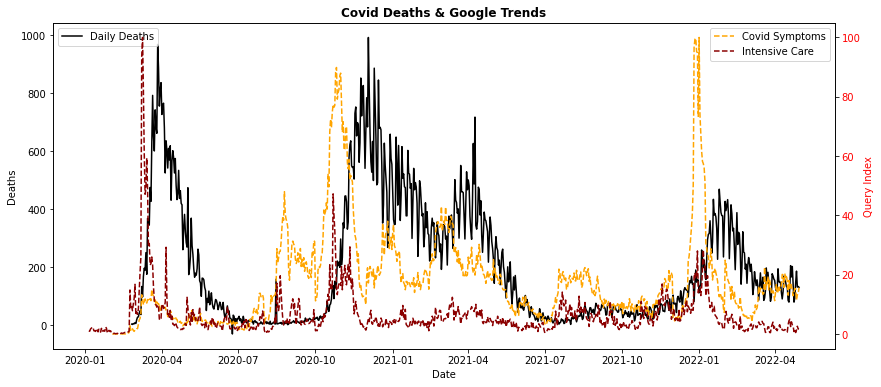

In [95]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Deaths')
ax1.plot(cov_data['delta_deceased'], color='black', label='Daily Deaths')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(ncol=1, loc='upper left', frameon=True)
ax2 = ax1.twinx()
ax2.set_ylabel('Query Index', color='red')
ax2.plot(trends['Covid Symptoms'], color='orange', linestyle='--', label='Covid Symptoms')
ax2.plot(trends['Intensive Care'], color='darkred', linestyle='--', label='Intensive Care')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(ncol=1, loc='upper right', frameon=True)
plt.title('Covid Deaths & Google Trends', fontweight='bold')

Text(0.5, 1.0, 'Covid ICUs Patients & Google Trends')

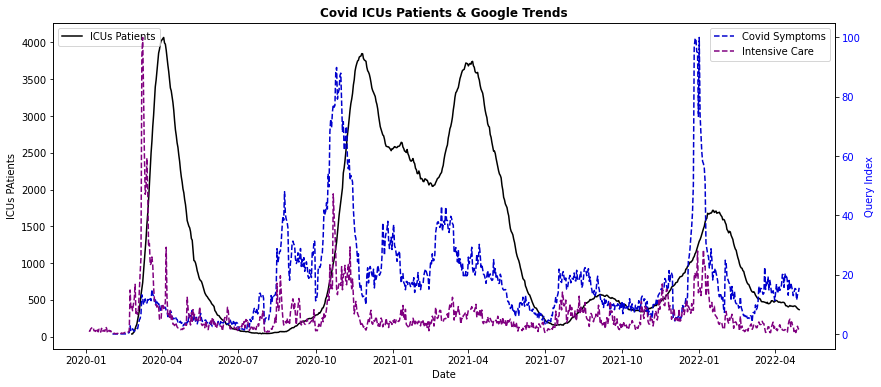

In [96]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date')
ax1.set_ylabel('ICUs PAtients')
ax1.plot(cov_data['intensive_care'], color='black', label='ICUs Patients')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(ncol=1, loc='upper left', frameon=True)
ax2 = ax1.twinx()
ax2.set_ylabel('Query Index', color='blue')
ax2.plot(trends['Covid Symptoms'], color='mediumblue', linestyle='--', label='Covid Symptoms')
ax2.plot(trends['Intensive Care'], color='purple', linestyle='--', label='Intensive Care')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(ncol=1, loc='upper right', frameon=True)
plt.title('Covid ICUs Patients & Google Trends', fontweight='bold')

Second, we need to define which time series model we are going to use.  
Here, my go-to approach is ***LASSO Regression***: my choice of [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) (Least Absolut Shrinkage and Selection Operator) is due to its performances both in variable selection as well as regularization capabilities.

Lasso achieves **limited overfitting** and **covariate selection** by forcing the sum of the absolute value of the regression coefficients to be less than a fixed value, which forces certain coefficients to zero, excluding them from impacting prediction. This idea is similar to *ridge regression*, which also shrinks the size of the coefficients.  

The LASSO implementation in Python comes in the *scikit-learn* packege: here, I will use *LassoCV*, which requires an evaluation method and a set of alpha values (the penalty factors, which couriously is called **lambda** in the literature) to choose from when performing feature selection.  

The first step in our implementation of LASSO regression in the time series domain is to write a [***rolling function***](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) that will perform model fitting and forecast n steps into the future, and then expand the training set with new data and forecast n steps further, keeping only the n-th prediction; this way, we are able to validate our model with metrics like [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) or [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) with a forecasting horizon of n steps into the future.

In [97]:
def lasso_rolling_forecast(y, X, n_train, n):

	""" Performs LASSO fitting and forecasts for n-days ahead
		Parameters: 
			y: daily indexed time series object 
			X: matrix of regressors to feed the model
			n_train: int, the number of observations to use for training
			n: number of steps ahead to forecast before retraining
	"""
	warnings.filterwarnings("ignore")
	preds = list() # predictions list
	n_records = len(y) # number of observations
	test = y.iloc[-(len(y)-n_train):] # complete testing set
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) # define model evaluation method

	for i in range(n_train, n_records):
		# training and testing updated after each prediction
		y_training, X_training, X_testing = y[0:i], X[0:i], X[i:i+n]
		# define model
		model = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)
		# fit model 
		model.fit(X_training, y_training)
		# n-days-ahead forecast (the length of rolling testing set)
		yhat = model.predict(X_testing)
		if i == n_train:	# predictions appended to list
			for p in yhat:
				preds.append(p) # the first n-ahead prediction array
		elif i < n_train+n:
			pass               # 
		else:
			preds.append(yhat[-1]) # all other n-ahead predictions
			
	return preds

Third, since we are employing external regressors, we have to **standardize** our data to ensure that the magnitude of the feature we want to predict and of Google Trends queries are comparable: LASSO is a linear model and does not account for it itself, therefore we have some dataframe manipulation to perform before employing the previously define function.  

Lastly, we have to obtain **lags** of 1,2 and 7 days our dependent variables (7 will also be the number of days ahead we want to forecast) and of 1,2,7 and 14 days for the queries we are going to use as external variables. We allow to lag up to 14 days for Google queries because of the peculiarity of the search terms: a person that search for Covid Symptoms on Google might end up in an Intensive Care Unit with some delay and lagging is our try in accounting for this fact.

To perform these operations, we will make use of *StandardScaler()* and of the *shift()* operators.

In [98]:
# all the queries are lagged by 1,2,7 and 14 days: this is done to assess the effect of queries made two weeks previous of the observed phenomenon

gt_coronavirus = trends[['Coronavirus']]
gt_coronavirus = pd.concat([gt_coronavirus, gt_coronavirus.shift(), gt_coronavirus.shift(2), gt_coronavirus.shift(7), gt_coronavirus.shift(14)], axis=1)
gt_coronavirus.columns = ['Coronavirus', 'Coronavirus_t_1', 'Coronavirus_t_2', 'Coronavirus_t_7', 'Coronavirus_t_14']

gt_sars = trends[['SARS-CoV-2']]
gt_sars = pd.concat([gt_sars, gt_sars.shift(), gt_sars.shift(2), gt_sars.shift(7), gt_sars.shift(14)], axis=1)
gt_sars.columns = ['SARS-Cov-2', 'SC2_t_1', 'SC2_t_2', 'SC2_t_7', 'SC2_t_14']

gt_symptoms = trends[['Covid Symptoms']]
gt_symptoms = pd.concat([gt_symptoms, gt_symptoms.shift(), gt_symptoms.shift(2), gt_symptoms.shift(7), gt_symptoms.shift(14)], axis=1)
gt_symptoms.columns = ['Covid Symptoms', 'CovSymptoms_t_1', 'CovSymptoms_t_2', 'CovSymptoms_t_7', 'CovSymptoms_t_14']

gt_vax = trends[['Covid Vaccine']]
gt_vax = pd.concat([gt_vax, gt_vax.shift(), gt_vax.shift(2), gt_vax.shift(7), gt_vax.shift(14)], axis=1)
gt_vax.columns = ['Covid Vaccine', 'CovVax_t_1', 'CovVax_t_2', 'CovVax_t_7', 'CovVax_t_14']

gt_icu = trends[['Intensive Care']]
gt_icu = pd.concat([gt_icu, gt_icu.shift(), gt_icu.shift(2), gt_icu.shift(7), gt_icu.shift(14)], axis=1)
gt_icu.columns = ['Intensive Care', 'IC_t_1', 'IC_t_2', 'IC_t_7', 'IC_t_14']

In [99]:
# empirical standard deviation of the features we are going to predict
sd_ic = cov_data['intensive_care'].std()
sd_np = cov_data['new_positives'].std()
sd_dd = cov_data['delta_deceased'].std()

# empirical mean of the features we are going to predict
avg_ic = cov_data['intensive_care'].mean()
avg_np = cov_data['new_positives'].mean()
avg_dd = cov_data['delta_deceased'].mean()

In [100]:
# intensive care cases are lagged
ic = cov_data[['intensive_care']]
ic = pd.concat([ic, ic.shift(), ic.shift(2), ic.shift(7)], axis=1).dropna()

# making sure all dfs have the same index before concatenation
gt_coronavirus = gt_coronavirus[gt_coronavirus.index >= ic.index[0]]
gt_sars = gt_sars[gt_sars.index >= ic.index[0]]
gt_symptoms = gt_symptoms[gt_symptoms.index >= ic.index[0]]
gt_vax = gt_vax[gt_vax.index >= ic.index[0]]
gt_icu = gt_icu[gt_icu.index >= ic.index[0]]

# concatenate Intensive Care Patients df and queries dataframes
ic = pd.concat([ic, gt_coronavirus, gt_sars, gt_symptoms, gt_vax, gt_icu], axis=1)

scaler = StandardScaler()
# transform data
ic = pd.DataFrame(scaler.fit_transform(ic))
ic = ic.set_index(keys=gt_coronavirus.index, drop=True, inplace=False)
ic.columns = ['intensive_care', 't_1', 't_2', 't_7', 
            'Coronavirus', 'Coronavirus_t_1', 'Coronavirus_t_2', 'Coronavirus_t_7', 'Coronavirus_t_14',
            'SARS-Cov-2', 'SC2_t_1', 'SC2_t_2', 'SC2_t_7', 'SC2_t_14',
            'Covid Symptoms', 'CovSymptoms_t_1', 'CovSymptoms_t_2', 'CovSymptoms_t_7', 'CovSymptoms_t_14',
            'Covid Vaccine', 'CovVax_t_1', 'CovVax_t_2', 'CovVax_t_7', 'CovVax_t_14',
            'Intensive Care', 'IC_t_1', 'IC_t_2', 'IC_t_7', 'IC_t_14']
ic.head()

,intensive_care,t_1,t_2,t_7,Coronavirus,Coronavirus_t_1,Coronavirus_t_2,Coronavirus_t_7,Coronavirus_t_14,SARS-Cov-2,...,Covid Vaccine,CovVax_t_1,CovVax_t_2,CovVax_t_7,CovVax_t_14,Intensive Care,IC_t_1,IC_t_2,IC_t_7,IC_t_14
date,,,,,,,,,,,,,,,,,,,,,
2020-03-03,-0.893774,-0.946886,-0.968504,-1.054052,2.478271,2.190669,2.224324,4.873334,-0.562840,-0.697267,...,-0.525984,-0.522799,-0.535967,-0.535578,-0.535201,0.001363,0.093898,-0.031251,0.297470,-0.729952
2020-03-04,-0.837723,-0.893393,-0.946433,-1.053205,3.823479,2.467719,2.180685,3.639236,-0.580909,-0.497322,...,-0.535991,-0.525959,-0.522799,-0.535578,-0.535201,0.206536,0.000496,0.093213,0.134102,-0.738849
2020-03-05,-0.790164,-0.837352,-0.892951,-1.036254,3.238606,3.809096,2.456920,3.022186,-0.580909,-0.605177,...,-0.535991,-0.535967,-0.525959,-0.535578,-0.535201,0.958786,0.205713,-0.000209,0.403660,-0.741815
2020-03-06,-0.695897,-0.789802,-0.836922,-1.029474,3.414068,3.225889,3.794349,2.315710,0.015386,-0.521024,...,-0.508778,-0.535967,-0.535967,-0.535578,-0.535201,1.667537,0.958125,0.205052,0.625544,-0.708600
2020-03-07,-0.606724,-0.695552,-0.789383,-0.994726,4.320674,3.400851,3.212858,2.521393,0.720099,-0.471445,...,-0.506496,-0.508754,-0.535967,-0.535578,-0.535201,2.289142,1.667028,0.957628,1.192731,-0.684282


In [101]:
# daily deaths variable is lagged
dd = cov_data[['delta_deceased']]
dd = pd.concat([dd, dd.shift(), dd.shift(2), dd.shift(7)], axis=1).dropna()
dd = pd.concat([dd, gt_coronavirus, gt_sars, gt_symptoms, gt_vax, gt_icu], axis=1)

scaler = StandardScaler()
# transform data
dd = pd.DataFrame(scaler.fit_transform(dd))
dd = dd.set_index(keys=gt_coronavirus.index, drop=True, inplace=False)
dd.columns = ['delta_deceased', 't_1', 't_2', 't_7', 
            'Coronavirus', 'Coronavirus_t_1', 'Coronavirus_t_2', 'Coronavirus_t_7', 'Coronavirus_t_14',
            'SARS-Cov-2', 'SC2_t_1', 'SC2_t_2', 'SC2_t_7', 'SC2_t_14',
            'Covid Symptoms', 'CovSymptoms_t_1', 'CovSymptoms_t_2', 'CovSymptoms_t_7', 'CovSymptoms_t_14',
            'Covid Vaccine', 'CovVax_t_1', 'CovVax_t_2', 'CovVax_t_7', 'CovVax_t_14',
            'Intensive Care', 'IC_t_1', 'IC_t_2', 'IC_t_7', 'IC_t_14']

# new positive cases is lagged            
new_p = cov_data[['new_positives']]
new_p = pd.concat([new_p, new_p.shift(), new_p.shift(2), new_p.shift(7)], axis=1).dropna()
new_p = pd.concat([new_p, gt_coronavirus, gt_sars, gt_symptoms, gt_vax, gt_icu], axis=1)

scaler = StandardScaler()
# transform data
new_p = pd.DataFrame(scaler.fit_transform(new_p))
new_p = new_p.set_index(keys=gt_coronavirus.index, drop=True, inplace=False)
new_p.columns = ['new_positives', 't_1', 't_2', 't_7', 
            'Coronavirus', 'Coronavirus_t_1', 'Coronavirus_t_2', 'Coronavirus_t_7', 'Coronavirus_t_14',
            'SARS-Cov-2', 'SC2_t_1', 'SC2_t_2', 'SC2_t_7', 'SC2_t_14',
            'Covid Symptoms', 'CovSymptoms_t_1', 'CovSymptoms_t_2', 'CovSymptoms_t_7', 'CovSymptoms_t_14',
            'Covid Vaccine', 'CovVax_t_1', 'CovVax_t_2', 'CovVax_t_7', 'CovVax_t_14',
            'Intensive Care', 'IC_t_1', 'IC_t_2', 'IC_t_7', 'IC_t_14']

Now we can finally put our rolling function to test, forecasting  the three Covid-related features using Google Trends as external predictors.

## 1. New Positives

In [102]:
# define training and testing lenghts 
train_size = int(len(new_p)*0.8)         
test_size = int(len(new_p) - train_size)
print("training set length is",train_size, "and testing set length is", test_size)

np_X = new_p.drop('new_positives', axis=1) # indipendent variables
np_y = new_p['new_positives'] # dependent variable

# using the rolling function and saving the predictions
pred_np = lasso_rolling_forecast(y=np_y, X=np_X, n_train=train_size, n=7)

training set length is 631 and testing set length is 158


In [103]:
test_np = cov_data['new_positives'].tail(test_size) # actual testing set
pred_np_df = pd.DataFrame(pred_np, index=test_np.index)

# creating a comparison dataframe
comparison_np = pd.merge(left=test_np, right=pred_np_df, left_index=True, right_index=True)
col_map_np = {comparison_np.columns[0]:'new_positives',comparison_np.columns[1]:'rolling_pred_lasso'}
comparison_np = comparison_np.rename(columns=col_map_np)

# de-standardizing predictions to compare with target 
comparison_np['rolling_pred_lasso'] = comparison_np['rolling_pred_lasso'].apply(lambda x: x*sd_np+avg_np)
comparison_np.head()

,new_positives,rolling_pred_lasso
2021-11-24,12448,10727.956876
2021-11-25,13764,11778.539240
2021-11-26,13686,12103.497727
2021-11-27,12877,11843.220129
2021-11-28,12932,10821.288689


In [104]:
# evaluate forecasts
RMSE_np = sqrt(mean_squared_error(comparison_np['new_positives'], comparison_np['rolling_pred_lasso']))
MAPE_np = mean_absolute_percentage_error(comparison_np['new_positives'], comparison_np['rolling_pred_lasso'])
print('Test RMSE: %.3f' % RMSE_np)
print('Test MAPE: %.3f' % MAPE_np)

Test RMSE: 33207.426
Test MAPE: 0.332


Text(0, 0.5, 'Cases')

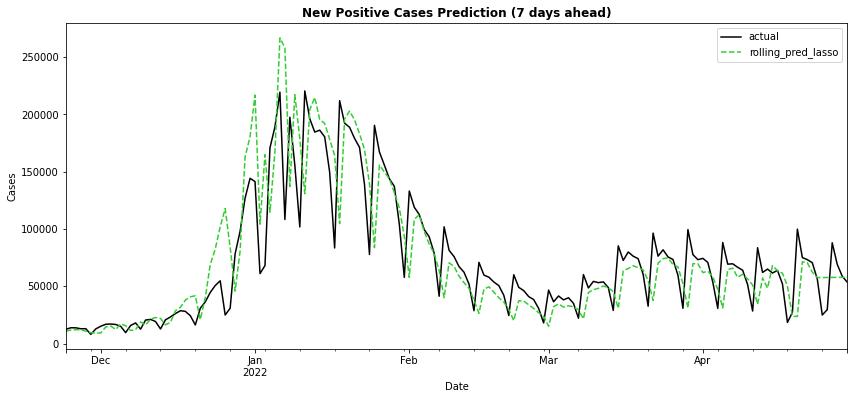

In [105]:
fig, ax = plt.subplots(figsize=(14, 6))
comparison_np['new_positives'].plot(color='black', label='actual')
comparison_np['rolling_pred_lasso'].plot(color='limegreen', linestyle='--')
ax.legend(ncol=1, loc='upper right', frameon=True)
plt.title('New Positive Cases Prediction (7 days ahead)', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cases')

##  2. ICUs Patients

In [106]:
ic_X = ic.drop('intensive_care', axis=1)
ic_y = ic['intensive_care']

# rolling prediction
pred_ic = lasso_rolling_forecast(y=ic_y, X=ic_X, n_train=train_size, n=7)

test_ic = cov_data['intensive_care'].tail(test_size) # actual testing set
pred_ic_df = pd.DataFrame(pred_ic, index=test_ic.index)

# creating a comparison dataframe
comparison_ic = pd.merge(left=test_ic, right=pred_ic_df, left_index=True, right_index=True)
col_map_ic = {comparison_ic.columns[0]:'intensive_care',comparison_ic.columns[1]:'rolling_pred_lasso'}
comparison_ic = comparison_ic.rename(columns=col_map_ic)

# de-standardizing predictions to compare with target 
comparison_ic['rolling_pred_lasso'] = comparison_ic['rolling_pred_lasso'].apply(lambda x: x*sd_ic+avg_ic)
comparison_ic

,intensive_care,rolling_pred_lasso
2021-11-24,573,560.206530
2021-11-25,588,572.601342
2021-11-26,606,590.880076
2021-11-27,624,618.006049
2021-11-28,638,632.203215
...,...,...
2022-04-26,409,353.891556
2022-04-27,394,353.881528
2022-04-28,382,353.804848
2022-04-29,371,353.793467


In [107]:
# evaluate forecasts
RMSE_ic = sqrt(mean_squared_error(comparison_ic['intensive_care'], comparison_ic['rolling_pred_lasso']))
MAPE_ic = mean_absolute_percentage_error(comparison_ic['intensive_care'], comparison_ic['rolling_pred_lasso'])
print('Test RMSE: %.3f' % RMSE_ic)
print('Test MAPE: %.3f' % MAPE_ic)

Test RMSE: 115.324
Test MAPE: 0.098


Text(0, 0.5, 'Cases')

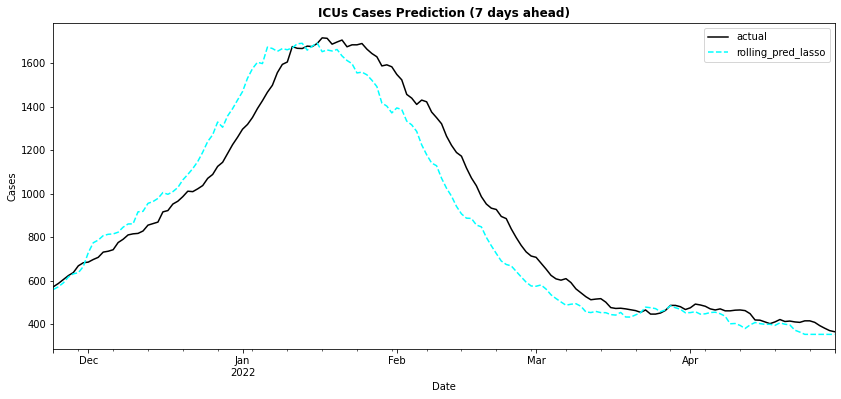

In [108]:
fig, ax = plt.subplots(figsize=(14, 6))
comparison_ic['intensive_care'].plot(color='black', label='actual')
comparison_ic['rolling_pred_lasso'].plot(color='cyan', linestyle='--')
ax.legend(ncol=1, loc='upper right', frameon=True)
plt.title('ICUs Cases Prediction (7 days ahead)', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cases')

## 3. Daily Deaths

In [109]:
dd_X = dd.drop('delta_deceased', axis=1)
dd_y = dd['delta_deceased']
# rolling prediction
pred_dd = lasso_rolling_forecast(y=dd_y, X=dd_X, n_train=train_size, n=7)

test_dd = cov_data['delta_deceased'].tail(test_size) # actual testing set
pred_dd_df = pd.DataFrame(pred_dd, index=test_dd.index)
# creating a comparison dataframe
comparison_dd = pd.merge(left=test_dd, right=pred_dd_df, left_index=True, right_index=True)
col_map_dd = {comparison_dd.columns[0]:'delta_deceased',comparison_dd.columns[1]:'rolling_pred_lasso'}
comparison_dd = comparison_dd.rename(columns=col_map_dd)

# de-standardizing predictions to compare with target 
comparison_dd['rolling_pred_lasso'] = comparison_dd['rolling_pred_lasso'].apply(lambda x: x*sd_dd+avg_dd)
comparison_dd

,delta_deceased,rolling_pred_lasso
2021-11-24,85.0,85.849221
2021-11-25,71.0,96.406432
2021-11-26,51.0,65.064937
2021-11-27,90.0,58.100173
2021-11-28,47.0,72.994169
...,...,...
2022-04-26,146.0,124.346394
2022-04-27,186.0,124.469324
2022-04-28,131.0,124.528962
2022-04-29,133.0,124.456432


In [110]:
# evaluate forecasts
RMSE_dd = sqrt(mean_squared_error(comparison_dd['delta_deceased'], comparison_dd['rolling_pred_lasso']))
MAPE_dd = mean_absolute_percentage_error(comparison_dd['delta_deceased'], comparison_dd['rolling_pred_lasso'])
print('Test RMSE: %.3f' % RMSE_dd)
print('Test MAPE: %.3f' % MAPE_dd)

Test RMSE: 61.885
Test MAPE: 0.253


Text(0, 0.5, 'Cases')

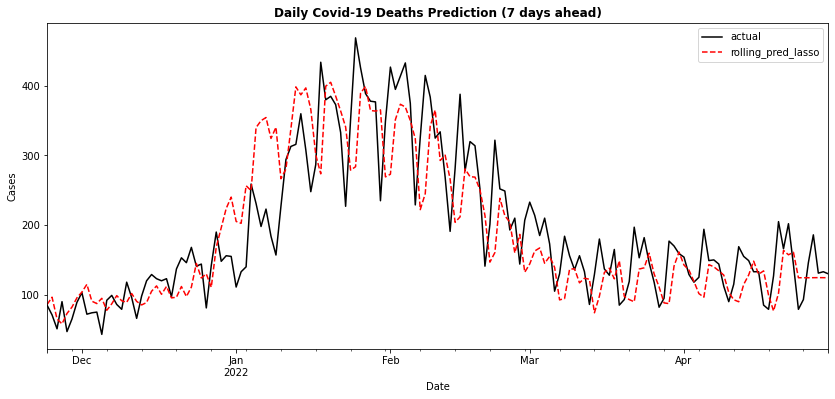

In [111]:
fig, ax = plt.subplots(figsize=(14, 6))
comparison_dd['delta_deceased'].plot(color='black', label='actual')
comparison_dd['rolling_pred_lasso'].plot(color='red', linestyle='--')
ax.legend(ncol=1, loc='upper right', frameon=True)
plt.title('Daily Covid-19 Deaths Prediction (7 days ahead)', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cases')

## CLOSING REMARKS  
Google Trends is a valuable source of information, especially if the investigated phenomenon does not allow for real time data collection. Google Trends Queries are fast to gather and disposable in near-real time, they are easy to understand because they represent relative interest in a given geographic location at a certain point in time; further, Google frequently cheks for data quality. However, when used for prediction purposes, some shrewdness has to be put in place by the forecaster:  
1. Deciding which terms/search queries might be the right predictor (if any) for a given phenomenon might be a difficult task: ***feature selection*** is important, and models that helps in that task are a useful resource;
2. The sample of data that Google makes available from its search database is constantly changing; generally, each sample is representative of all searches, but data downloaded in different days will not be exactly the same, though very similar; to ensure the time series consistency, it is advisable to ***average*** across different samples.
3. It might happen that the phenomenon that we are investigating (say, people ending up as patients in intensive care units) is related to searches which took place several days before (for instance, "*Covid Symptoms*"). An analysis of ***lags*** to implement (omitted here for brevity's sake) is overdue to account for this feature.